### 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений. В материалах также есть пример скрипта для расчета дерева - Lesson_4_script, им можно воспользоваться аналогично тому, как это было на предыдущих уроках.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [3]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data # значения признаков
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        prediction = np.mean(self.labels)

        return prediction

In [4]:
def build_tree(data, labels, max_depth=3, depth=0, min_leaf=2):
# -------------------------
# --------Мои правки-------
# Добавление критерия остановки по глубине дерева

    if max_depth == depth:
        return Leaf(data, labels)
# -------------------------
    
    quality, t, index = find_best_split(data, labels, min_leaf) # ищем лучшее разбиение
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    # неопределенность после разбиения осталась такой же как до
    if quality == 0: # критерий останова
#         print('leaf')
        return Leaf(data, labels) # считаем прогноз для листьев

    # если качество улучшилось, то делим дерево по лучшему разбиению
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    # -------------------------
    # --------Мои правки-------
    # Добавляем на вход дополнительные параметры 
    true_branch = build_tree(true_data, true_labels, max_depth, depth+1)
    false_branch = build_tree(false_data, false_labels, max_depth, depth+1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [5]:
def find_best_split(data, labels, min_leaf):
    
     #  min_leaf задается как входной параметр 

    current_dispersion = dispersion(labels) 

    best_quality = 0
    best_t = None # лучший порог разбиения
    best_index = None # лучший индекс разбиения
    
    n_features = data.shape[1] # кол-во признаков
    
    for index in range(n_features): # проход по всем признакам
        t_values = [row[index] for row in data] # берем столбец/признак с соотв. индексом
        
        for t in t_values: # проход по признаку
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t) # делаем разбиение
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue # начинаем следующий проход цикла, минуя оставшееся тело цикла
            
            # расчет качества текущего разбиения
            current_quality = quality(true_labels, false_labels, current_dispersion)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [6]:
# Расчет критерия Джини

def dispersion(labels):
    return np.mean((labels - np.mean(labels))**2)

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_dispersion):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels) # Функционал качества

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree) # определяем ветки для объектов
        classes.append(prediction)
    return classes

In [10]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf): # проверка текущий узел это лист?
        answer = node.prediction # считаем прогноз для листа
        return answer

    if obj[node.index] <= node.t: # если значение признака меньше порога t
        return classify_object(obj, node.true_branch) # рекурсия: отправляем объект в true-ветку
    else:
        return classify_object(obj, node.false_branch) # рекурсия: отправляем объект в false-ветку

In [11]:
# Возьмем 2 признака и 100 объектов
n_features = 2
n_objects = 100

# сгенерируем вектор истинных весов
w_true = np.random.normal(size=(n_features, ))

# сгенерируем матрицу X, вычислим Y с добавлением случайного шума
X = np.random.uniform(-7, 7, (n_objects, n_features))
Y = X.dot(w_true) + np.random.normal(0, 0.5, size=(n_objects))

# возьмем нулевые начальные веса
# w = np.zeros(n_features)

# display(w_true, X, w, Y)
# Y.shape

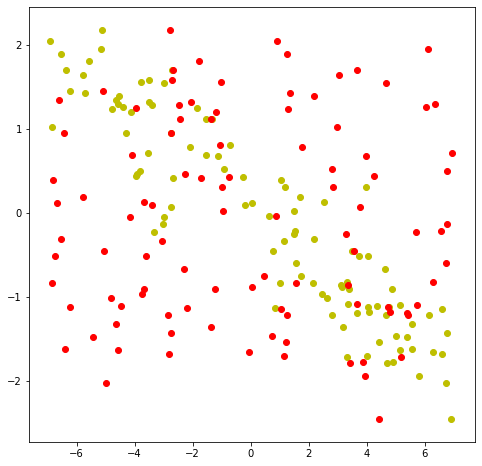

In [12]:
# визуализируем сгенерированные данные
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], Y, c = 'y')
plt.scatter(X[:,1], Y, c = 'r')

In [13]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing="", i=1):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + str(i) + '--> True:')
    print_tree(node.true_branch, spacing + "  ", i+1)

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + str(i) + '--> False:')
    print_tree(node.false_branch, spacing + "  ", i+1)
    


In [14]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(X, 
                                                                                     Y, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [23]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth = 7, min_leaf=7)

In [24]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)
train_answers[:5]

[-1.5838735707105926,
 -1.4718379657135625,
 1.3347073434712462,
 1.9735436694264128,
 1.290333953126305]

In [25]:
# И получим ответы для тестовой выборкиb
answers = predict(test_data, my_tree)

In [26]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(y, y_pred):
    return (sum((y - y_pred)**2)) / len(y)

In [27]:
# Точность на обучающей выборке
err = mserror(train_labels, train_answers)
err

0.062235412701783815

In [28]:
# Точность на тестовой выборке
err = mserror(test_labels, np.array(answers).T)
err

0.26194332396029885

In [29]:
# print_tree(my_tree)

In [31]:
def normal_equation(X, y):
    return np.linalg.solve((X.T).dot(X), (X.T).dot(y))

normal_eq_w = normal_equation(train_data, train_labels)
print(normal_eq_w)
print(f'В случае использования нормального уравнения функционал ошибки составляет - train {round(mserror(train_labels, np.dot(train_data, normal_eq_w)), 4)}')
print(f'В случае использования нормального уравнения функционал ошибки составляет - test  {round(mserror(test_labels , np.dot(test_data, normal_eq_w)), 4)}')

[-0.26946392 -0.03077849]
В случае использования нормального уравнения функционал ошибки составляет - train 0.2418
В случае использования нормального уравнения функционал ошибки составляет - test  0.1274
